In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### install & import

In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install pytorch-lightning
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 13.0 MB/s 
     |████████████████████████████████| 125 kB 91.3 MB/s 
     |████████████████████████████████| 512 kB 96.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 14.0 MB/s 
     |████████████████████████████████| 33.8 MB 1.2 MB/s 
     |████████████████████████████████| 308 kB 92.4 MB/s 
     |████████████████████████████████| 209 kB 93.0 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 147 kB 85.7 MB/s 
     |██████████████████████

In [3]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import os

In [4]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [5]:
from pytorch_forecasting.metrics import MultiHorizonMetric
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class TweedieLoss(MultiHorizonMetric):
    """
    Tweedie loss.

    Tweedie regression with log-link. It might be useful, e.g., for modeling total
    loss in insurance, or for any target that might be tweedie-distributed.

    The loss will take the exponential of the network output before it is returned as prediction.
    Target normalizer should therefore have no "reverse" transformation, e.g.
    for the :py:class:`~data.timeseries.TimeSeriesDataSet` initialization, one could use:

    .. code-block:: python

        from pytorch_forecasting import TimeSeriesDataSet, EncoderNormalizer

        dataset = TimeSeriesDataSet(
            target_normalizer=EncoderNormalizer(transformation=dict(forward=torch.log1p))
        )

    Note that in this example, the data is log1p-transformed before normalized but not re-transformed.
    The TweedieLoss applies this "exp"-re-transformation on the network output after it has been de-normalized.
    The result is the model prediction.
    """

    def __init__(self, reduction="mean", p: float = 1.5, **kwargs):
        """
        Args:
            p (float, optional): tweedie variance power which is greater equal
                1.0 and smaller 2.0. Close to ``2`` shifts to
                Gamma distribution and close to ``1`` shifts to Poisson distribution.
                Defaults to 1.5.
            reduction (str, optional): How to reduce the loss. Defaults to "mean".
        """
        super().__init__(reduction=reduction, **kwargs)
        assert 1 <= p < 2, "p must be in range [1, 2]"
        self.p = p

    def to_prediction(self, out: Dict[str, torch.Tensor]):
        rate = torch.exp(super().to_prediction(out))
        return rate


    def loss(self, y_pred, y_true):
        y_pred = super().to_prediction(y_pred)
        a = y_true * torch.exp(y_pred * (1 - self.p)) / (1 - self.p)
        b = torch.exp(y_pred * (2 - self.p)) / (2 - self.p)
        loss = -a + b
        return loss


### load data

In [6]:
#os.chdir("/content/drive/MyDrive/소캡디/code")
os.chdir("/content/drive/MyDrive/4-1/소캡디/code")

##### training data (encode data) : 모델 load 용도로 사용

In [7]:
data = pd.read_pickle("./data_use/CA_1_final_grid_df.pkl")

In [8]:
values = {"rolling_mean_7": 0, "rolling_mean_14": 0, "rolling_mean_30": 0, "rolling_mean_60":0, "rolling_mean_180":0,
          "rolling_std_7":0,"rolling_std_14":0, "rolling_std_30":0, "rolling_std_60":0,"rolling_std_180":0}
data.fillna(values, inplace=True)
data.drop(columns = ['id','store_id','state_id'],inplace=True)

data["log_sales"] = np.log(data.sales + 0.0001)

In [9]:
encode_data = data.copy()
encode_data = encode_data.dropna(subset=['sales']) #test data 삭제
encode_data.reset_index(drop=True)

,item_id,dept_id,cat_id,d,sales,release,sell_price,price_max,price_min,price_std,...,rolling_std_60,rolling_mean_180,rolling_std_180,enc_cat_id_mean,enc_cat_id_std,enc_dept_id_mean,enc_dept_id_std,enc_item_id_mean,enc_item_id_std,log_sales
0,HOBBIES_1_008,HOBBIES_1,HOBBIES,1,12.0,0,0.459961,0.500000,0.419922,0.019760,...,0.000000,0.000000,0.000000,1.003906,3.115234,1.259766,3.533203,7.285156,9.179688,2.484915
1,HOBBIES_1_009,HOBBIES_1,HOBBIES,1,2.0,0,1.559570,1.769531,1.559570,0.032745,...,0.000000,0.000000,0.000000,1.003906,3.115234,1.259766,3.533203,1.178711,2.013672,0.693197
2,HOBBIES_1_010,HOBBIES_1,HOBBIES,1,0.0,0,3.169922,3.169922,2.970703,0.046356,...,0.000000,0.000000,0.000000,1.003906,3.115234,1.259766,3.533203,0.716797,0.919434,-9.210340
3,HOBBIES_1_012,HOBBIES_1,HOBBIES,1,0.0,0,5.980469,6.519531,5.980469,0.115967,...,0.000000,0.000000,0.000000,1.003906,3.115234,1.259766,3.533203,0.392090,0.646973,-9.210340
4,HOBBIES_1_015,HOBBIES_1,HOBBIES,1,4.0,0,0.700195,0.720215,0.680176,0.011337,...,0.000000,0.000000,0.000000,1.003906,3.115234,1.259766,3.533203,6.015625,7.324219,1.386319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4788262,FOODS_3_823,FOODS_3,FOODS,1941,2.0,127,2.980469,2.980469,2.480469,0.152222,...,1.242188,1.555664,1.825195,2.419922,5.882812,3.119141,7.214844,0.822266,1.382812,0.693197
4788263,FOODS_3_824,FOODS_3,FOODS,1941,0.0,0,2.480469,2.679688,2.470703,0.086365,...,1.166992,0.133301,0.696289,2.419922,5.882812,3.119141,7.214844,0.717773,1.205078,-9.210340
4788264,FOODS_3_825,FOODS_3,FOODS,1941,1.0,1,3.980469,4.378906,3.980469,0.189697,...,0.986328,0.850098,1.075195,2.419922,5.882812,3.119141,7.214844,0.964844,1.354492,0.000100
4788265,FOODS_3_826,FOODS_3,FOODS,1941,1.0,211,1.280273,1.280273,1.280273,0.000000,...,1.396484,1.016602,1.404297,2.419922,5.882812,3.119141,7.214844,1.576172,1.843750,0.000100


### load best model

In [10]:
max_prediction_length = 28  # maximum prediction/decoder length (choose this not too short as it can help convergence) 
max_encoder_length = 90 # maximum length to encode. This is the maximum history length used by the time series dataset. #1년은 ram용량 없어짐 -> 로컬환경 구축
training_cutoff = encode_data["d"].max() - max_prediction_length #training set에 사용할 time만큼

training = TimeSeriesDataSet(
    encode_data[lambda x: x["d"] <= training_cutoff],
    time_idx="d",
    target="sales",
    group_ids=["item_id"],
    min_encoder_length= 1,
    max_encoder_length= max_encoder_length,
    min_prediction_length= 1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["item_id","dept_id","cat_id"], #시간이 지나도 변하지 않는 categorical
    static_reals=["release","price_max","price_min","price_std","price_mean","price_nunique",  "enc_cat_id_mean", "enc_cat_id_std", "enc_dept_id_mean", "enc_dept_id_std",
                  "enc_item_id_mean", "enc_item_id_std"], # 시간이 지나도 변하지 않는 continuous variables
    # list of categorical variables that change over time and are known in the future
    time_varying_known_categoricals=["snap_CA", "snap_TX","snap_WI","tm_w_end","event_name_1","event_name_2","event_type_1","event_type_2"], 
    # list of continuous variables that change over time and are known in the future
    time_varying_known_reals=["d","tm_d","tm_w",'tm_m',"tm_y","tm_wm","tm_dw","sell_price","price_norm","price_momentum","price_momentum_m","price_momentum_y",
                              "rolling_mean_7", "rolling_mean_14", "rolling_mean_30", "rolling_mean_60", "rolling_mean_180",
                              "rolling_std_7","rolling_std_14", "rolling_std_30", "rolling_std_60","rolling_std_180"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sales","log_sales"],
#    target_normalizer=GroupNormalizer(
#        groups=["item_id"], transformation="softplus"
#    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


In [11]:
loaded_model = tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0845,
    hidden_size=20, 
    attention_head_size=1,
    dropout=0.265,
    hidden_continuous_size=10,
    output_size=1,  # point로 바꿔서 1로 변경
    loss= TweedieLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

loaded_model.load_state_dict(torch.load('./model_build/tft_best_model_1207_store.pt'))
loaded_model.eval()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


TemporalFusionTransformer(
  	"attention_head_size":               1
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.265
  	"embedding_labels":                  {'item_id': {'FOODS_1_001': 0, 'FOODS_1_002': 1, 'FOODS_1_003': 2, 'FOODS_1_004': 3, 'FOODS_1_005': 4, 'FOODS_1_006': 5, 'FOODS_1_008': 6, 'FOODS_1_009': 7, 'FOODS_1_010': 8, 'FOODS_1_011': 9, 'FOODS_1_012': 10, 'FOODS_1_013': 11, 'FOODS_1_014': 12, 'FOODS_1_015': 13, 'FOODS_1_016': 14, 'FOODS_1_017': 15, 'FOODS_1_018': 16, 'FOODS_1_019': 17, 'FOODS_1_020': 18, 'FOODS_1_021': 19, 'FOODS_1_022': 20, 'FOODS_1_023': 21, 'FOODS_1_024': 22, 'FOODS_1_025': 23, 'FOODS_1_026': 24, 'FOODS_1_027': 25, 'FOODS_1_028': 26, 'FOODS_1_029': 27, 'FOODS_1_030': 28, 'FOODS_1_031': 29, 'FOODS_1_032': 30, 'FOODS_1_033': 31, 'FOODS_1_034': 32, 'FOODS_1_035': 33, 'FOODS_1_036': 34, 'FOODS_1_037': 35, 'FOODS_1_038': 36, 'FOODS_1_039': 37, 'FOODS_1_040': 38, 'FOODS_1_041'

### test data 예측

In [12]:
batch_size = 128  
validation = TimeSeriesDataSet.from_dataset(training, encode_data, predict=True, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True,batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [13]:
raw_predictions, x = loaded_model.predict(val_dataloader, mode="raw", return_x=True)

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x468 with 1 Axes>,
 'encoder_variables': <Figure size 504x738 with 1 Axes>,
 'decoder_variables': <Figure size 504x702 with 1 Axes>}

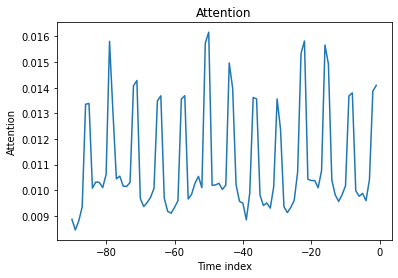

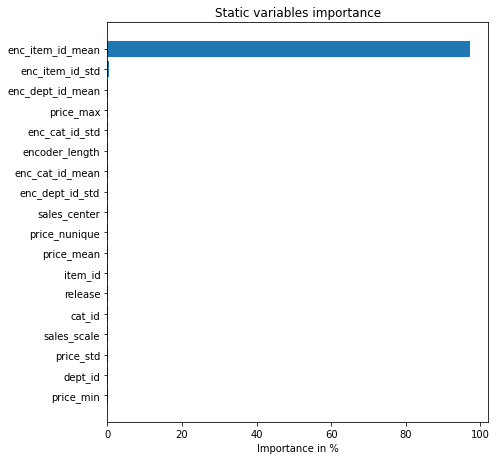

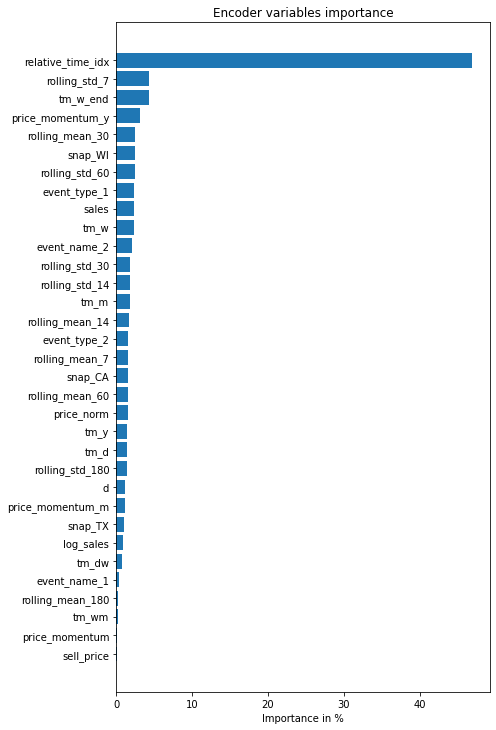

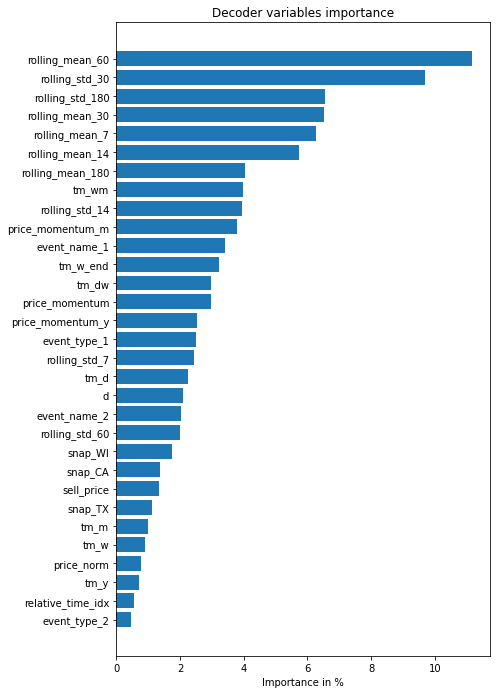

In [14]:
interpretation = loaded_model.interpret_output(raw_predictions, reduction="sum")
loaded_model.plot_interpretation(interpretation)

In [15]:
interpretation

{'attention': tensor([27.0177, 25.7537, 26.8228, 28.4903, 40.7164, 40.8059, 30.7289, 31.4569,
         31.4103, 30.7949, 32.3491, 48.1966, 39.7686, 31.8348, 32.1548, 30.9628,
         30.9294, 31.3994, 42.9005, 43.5379, 29.4910, 28.5398, 29.0109, 29.6289,
         30.7038, 41.1155, 41.7196, 29.5390, 27.9617, 27.7475, 28.4316, 29.2194,
         41.3190, 41.7358, 29.4364, 30.0000, 31.3284, 32.1307, 30.7769, 47.9861,
         49.2848, 31.0536, 31.1141, 31.3047, 30.5737, 31.0825, 45.6329, 42.6120,
         31.1183, 29.1600, 28.9305, 26.9492, 30.1471, 41.5240, 41.3434, 29.8906,
         28.6597, 28.9589, 28.3456, 30.8810, 41.3518, 37.7275, 28.5197, 27.8147,
         28.4314, 29.2718, 32.6210, 46.7755, 48.2434, 31.7798, 31.6335, 31.6245,
         30.7723, 32.8014, 47.7682, 45.5018, 31.6874, 29.9141, 29.1429, 29.9443,
         30.9929, 41.7074, 42.0577, 30.4136, 29.7631, 30.0950, 29.2359, 31.7390,
         42.2885, 42.9596]),
 'static_variables': tensor([4.1376e+00, 3.2269e+00, 4.0729e+00, 4.

----------------------------------------------------------------------------------------------------------------------------------------------------------------